In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
import numpy as np
import matplotlib.pyplot as plt
import pickle
from torch.utils.data import TensorDataset, DataLoader
from pytorch_lightning.callbacks import ModelCheckpoint
from scipy.io import wavfile

class CausalConv1d(torch.nn.Conv1d):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, dilation=1, groups=1, bias=True):
        self.__padding = (kernel_size - 1) * dilation

        super(CausalConv1d, self).__init__(
            in_channels,
            out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=self.__padding,
            dilation=dilation,
            groups=groups,
            bias=bias,
        )
        '''
        print ("Dilation: ", dilation)
        print ("Input Channels", in_channels)
        print ("Output Channels: ", out_channels)
        '''

    def forward(self, input):
        result = super(CausalConv1d, self).forward(input)
        if self.__padding != 0:
            return result[:, :, : -self.__padding]
        return result


def _conv_stack(dilations, in_channels, out_channels, kernel_size):
    """
    Create stack of dilated convolutional layers, outlined in WaveNet paper:
    https://arxiv.org/pdf/1609.03499.pdf
    """
    return nn.ModuleList(
        [
            CausalConv1d(
                in_channels=in_channels,
                out_channels=out_channels,
                dilation=d,
                kernel_size=kernel_size,
            )
            for i, d in enumerate(dilations)
        ]
    )


class WaveNet(nn.Module):
    def __init__(self, num_channels, dilation_depth, num_repeat, kernel_size=2):
        super(WaveNet, self).__init__()
        dilations = [2 ** d for d in range(dilation_depth)] * num_repeat
        internal_channels = int(num_channels * 2)

        #print ("HIDDENS")
        self.hidden = _conv_stack(dilations, num_channels, internal_channels, kernel_size)

        #print ("RESIDUALS")
        self.residuals = _conv_stack(dilations, num_channels, num_channels, 1)

        self.input_layer = CausalConv1d(
            in_channels=1,
            out_channels=num_channels,
            kernel_size=1,
        )

        self.linear_mix = nn.Conv1d(
            in_channels=num_channels * dilation_depth * num_repeat,
            out_channels=1,
            kernel_size=1,
        )
        self.num_channels = num_channels

    def forward(self, x):
        out = x
        skips = []
        out = self.input_layer(out)

        for hidden, residual in zip(self.hidden, self.residuals):
            x = out
            out_hidden = hidden(x)

            # gated activation
            #   split (32,16,3) into two (16,16,3) for tanh and sigm calculations
            out_hidden_split = torch.split(out_hidden, self.num_channels, dim=1)
            out = torch.tanh(out_hidden_split[0]) * torch.sigmoid(out_hidden_split[1])

            skips.append(out)

            out = residual(out)
            out = out + x[:, :, -out.size(2) :]

        # modified "postprocess" step:
        out = torch.cat([s[:, :, -out.size(2) :] for s in skips], dim=1)
        out = self.linear_mix(out)
        return out


def error_to_signal(y, y_pred):
    """
    Error to signal ratio with pre-emphasis filter:
    https://www.mdpi.com/2076-3417/10/3/766/htm
    """
    y, y_pred = pre_emphasis_filter(y), pre_emphasis_filter(y_pred)
    return (y - y_pred).pow(2).sum(dim=2) / (y.pow(2).sum(dim=2) + 1e-10)


def pre_emphasis_filter(x, coeff=0.95):
    return torch.cat((x[:, :, 0:1], x[:, :, 1:] - coeff * x[:, :, :-1]), dim=2)


class SatNet(pl.LightningModule):
    def __init__(self, hparams):
        super(SatNet, self).__init__()
        self.wavenet = WaveNet(
            num_channels=hparams["num_channels"],
            dilation_depth=hparams["dilation_depth"],
            num_repeat=hparams["num_repeat"],
            kernel_size=hparams["kernel_size"],
        )
        self.hparams.update(hparams)
        self.save_hyperparameters()
        self.test_ds = TensorDataset()

    def prepare_data(self):

        createTensorDataset = lambda x, y: TensorDataset(torch.from_numpy(x).unsqueeze(1), torch.from_numpy(y).unsqueeze(1))
        
        inRate, inData = wavfile.read(self.hparams["in_file"])
        outRate, outData = wavfile.read(self.hparams["out_file"])
        sampleTime = 0.1
        sampleSize = int(inRate * sampleTime)
        length = len(inData) - len(inData) % sampleSize

        #Each row in this table represents the waveform samples seen in 0.1 seconds (4410 samples)
        x = inData[:length].reshape((-1, sampleSize)).astype(np.float32)
        y = outData[:length].reshape((-1, sampleSize)).astype(np.float32)

        splitLocA = int(len(x) * 0.6)
        splitLocB = int(len(x) * 0.8)

        X_train, X_valid, X_test = np.split(x, [splitLocA, splitLocB])
        y_train, y_valid, y_test = np.split(y, [splitLocA, splitLocB])

        self.train_ds = createTensorDataset(X_train, y_train)
        self.valid_ds = createTensorDataset(X_valid, y_valid)
        self.test_ds = createTensorDataset(X_test, y_test)

    def configure_optimizers(self):
        return torch.optim.Adam(self.wavenet.parameters(), lr=self.hparams.learning_rate)

    def train_dataloader(self):
        return DataLoader(
            self.train_ds,
            shuffle=True,
            batch_size=self.hparams.batch_size,
            num_workers=4,
        )

    def val_dataloader(self):
        return DataLoader(self.valid_ds, batch_size=self.hparams.batch_size, num_workers=4)

    def forward(self, x):
        return self.wavenet(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self.forward(x)
        loss = error_to_signal(y[:, :, -y_pred.size(2) :], y_pred).mean()
        self.log("loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self.forward(x)
        loss = error_to_signal(y[:, :, -y_pred.size(2) :], y_pred).mean()
        return loss

    def validation_epoch_end(self, outs):
        lossArray = []
        for tensor in outs:
            lossArray.append(tensor.item())
        avg_loss = (np.asarray(lossArray)).mean()
        self.log("avg_val_loss", avg_loss)

In [16]:
checkpoint_callback = ModelCheckpoint(
    monitor = "avg_val_loss",
    dirpath = "models\\newPLModelTest\\",
    filename = "sample-mnist-{epoch:02d}-{avg_val_loss:.4f}",
    save_top_k = 3,
    mode = "min"
)

hparams = {
    "in_file": "data\\y_input_data.wav",
    "out_file": "data\\x_input_data.wav",
    "num_channels": 12,
    "dilation_depth": 10,
    "num_repeat": 1,
    "kernel_size": 3,
    "learning_rate": 3e-3,
    "batch_size": 64
}

satnet = SatNet(hparams)
 
trainer = pl.Trainer(gpus = -1, max_epochs = 1, callbacks = [checkpoint_callback])
trainer.fit(satnet)
trainer.save_checkpoint("models\\newPLModelTest\\finalEpochSatnet.ckpt")

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\Shadow\AppData\Local\Programs\Python\Python37\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:608: UserWarning: Checkpoint directory c:\Users\Shadow\Documents\Project\models\newPLModelTest exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params
------------------------------------
0 | wavenet | WaveNet | 10.6 K
------------------------------------
10.6 K    Trainable params
0         Non-trainable params
10.6 K    Total params
0.042     Total estimated model params size (MB)


C:\Users\Shadow\AppData\Local\Programs\Python\Python37\lib\site-packages\pytorch_lightning\trainer\trainer.py:1931: PossibleUserWarning: The number of training batches (18) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Epoch 0: 100%|██████████| 24/24 [00:09<00:00,  2.53it/s, loss=1.04e+03, v_num=15]


In [14]:
#TEMP
model = SatNet.load_from_checkpoint("models\\newPLModelTest\\finalEpochSatnet.ckpt")
layers = list(model.named_modules())

layer = layers[3][1]
print (layer.weight.size())

torch.Size([24, 12, 3])


In [5]:
#Pickle generated datasets for later use on corresponding generated model (assuming not in same session)
datasets = [satnet.train_ds, satnet.valid_ds, satnet.test_ds]
datasetNames = ["train_ds", "valid_ds", "test_ds"]

for i in range(len(datasets)):
    pickle.dump(datasets[i], open("models\\model_" + datasetNames[i] + ".pickle", "wb"))

In [7]:
#Unpickle test dataset
#test_ds = pickle.load(open("models\\model_test_ds.pickle", "rb"))

def save(name, data):
    wavfile.write(name, 44100, data.flatten().astype(np.float32))

finalModel = SatNet.load_from_checkpoint("models\sample-mnist-epoch=1495-avg_val_loss=0.0330.ckpt")

#If SatNet instantiated in the same session as execution of this cell
loader = DataLoader(satnet.test_ds, batch_size = len(satnet.test_ds))

#If loading test dataset from pickle file
#loader = DataLoader(test_ds, batch_size = len(test_ds))

x_test = next(iter(loader))[0].numpy()
y_test = next(iter(loader))[1].numpy()

prev_sample = np.concatenate((np.zeros_like(x_test[0:1]), x_test[:-1]), axis=0)
pad_x_test = np.concatenate((prev_sample, x_test), axis=2)


y_prediction = []
for x in np.array_split(pad_x_test, 10):
    y_prediction.append(finalModel(torch.from_numpy(x)).detach().numpy())

y_prediction = np.concatenate(y_prediction)
y_prediction = y_prediction[:, :, -x_test.shape[2] :]

prev_sample = np.concatenate((np.zeros_like(x_test[0:1]), x_test[:-1]), axis=0)
pad_x_test = np.concatenate((prev_sample, x_test), axis=2)

save("models\\x_test.wav", x_test)
save("models\\y_test.wav", y_test)
save("models\\y_prediction.wav", y_prediction)

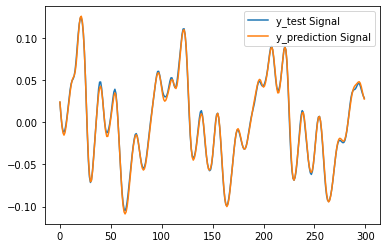

In [8]:
y_test_sampleRate, y_test = wavfile.read("models\\y_test.wav")
y_prediction_sampleRate, y_prediction = wavfile.read("models\\y_prediction.wav")

plotStartPoint = 5500

plt.plot(y_test[plotStartPoint:plotStartPoint + 300], label = "y_test Signal")
plt.plot(y_prediction[plotStartPoint:plotStartPoint + 300], label = "y_prediction Signal")
plt.legend()
plt.savefig("models\\waveformCompPlot.png")
plt.show()